1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

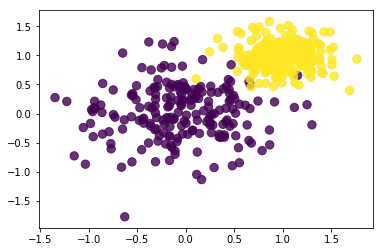

In [2]:
from IPython.display import Image
Image('data_ex/two_categories_scatter_plot.png')

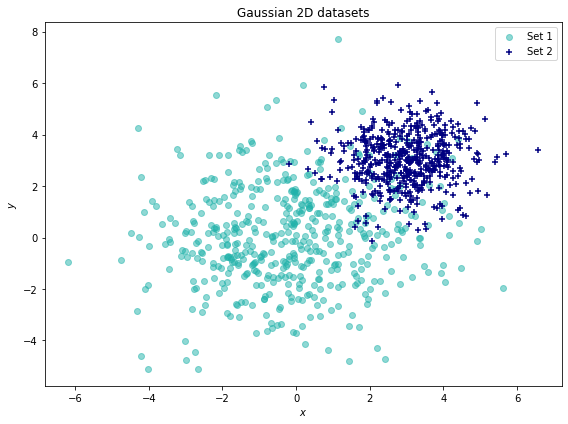

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generate2D(mean, sigma):
     return np.random.normal(loc=mean, scale=sigma, size=1000).reshape(500,2)


s1 = generate2D(0,2)
s2 = generate2D(3,1)

fig, _ = plt.subplots(figsize=(8, 6))
plt.scatter(s1[:,0], s1[:,1], c='lightseagreen', label="Set 1",alpha=.5)
plt.scatter(s2[:,0], s2[:,1], c='navy', marker="+", label="Set 2")  
plt.title("Gaussian 2D datasets")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend(loc="best")
fig.tight_layout()


2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [13]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P ~/Dropbox/Università/Esami\ in\ corso/high\ level\ programming/Githb\ branch/exercises/data_ex/    
    

--2021-11-29 13:16:48--  https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3uqleyc3wyz52tr/residuals_261.pkl [following]
--2021-11-29 13:16:49--  https://www.dropbox.com/s/raw/3uqleyc3wyz52tr/residuals_261.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc191afd919aa0d5101619ee036e.dl.dropboxusercontent.com/cd/0/inline/Ba5hiM1zuHU1FVUUdDGfSGyeWoXsohnE7YQrx-W-AdHabQacuGAZZKLaC6K-mIYHW9Cv0S4P5PUDaWHKxZlshdcGK9CL5CZ_mcyZeYnPLuV0wLS9ECqPtXjEGIdq-QMqU1GBOKEd5cYwl_egt9PRSSTy/file# [following]
--2021-11-29 13:16:49--  https://uc191afd919aa0d5101619ee036e.dl.dropboxusercontent.com/cd/0/inline/Ba5hiM1zuHU1FVUUdDGfSGyeWoXsohnE7YQrx-W-AdHabQacuGAZZKLaC6K-mIYHW9Cv0S4P5PUDaWHKxZlshdcGK9CL5CZ_mcyZe

In [1]:
import pandas as pd
import seaborn as sns

x=pd.read_pickle("data_ex/residuals_261.pkl")
print(x,'\n', type(x))

df = pd.DataFrame(x.item()) #.item method to extract the dict

df = df[abs(df['residuals'])<2] #cleaning residuals >2
df.head()

{'residuals': array([ 1.1       , -1.95      , -7.2       , ...,  0.08333333,
        0.16666667,  0.08333333]), 'distances': array([16. ,  6.3,  3.4, ...,  1.7, 19.1,  2.6])} 
 <class 'numpy.ndarray'>


,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0


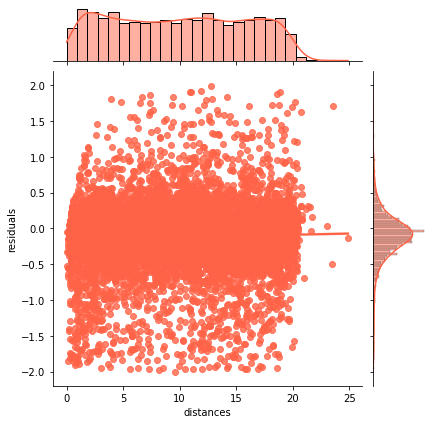

In [2]:
sns.jointplot(x="distances", y="residuals", color="tomato", data=df, kind="reg")

#distances seem to follow an uniform distribution from 0 to 20
#residuals follow a normal disribution with mean 0
#There's a very small correlation between the two. Indeed the residuals are almost constant with respect distances

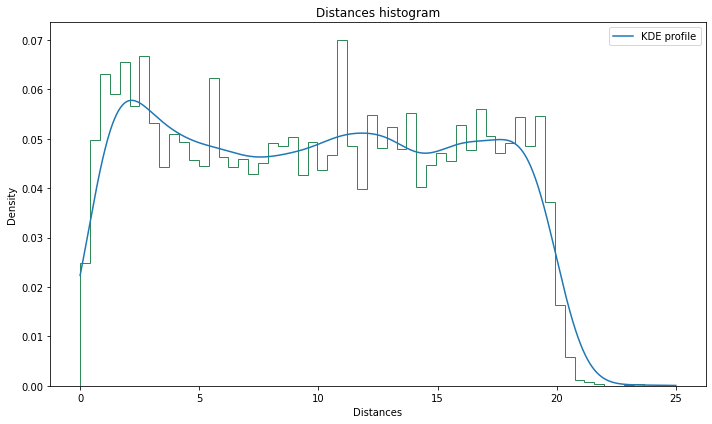

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
h, bins, _ = plt.hist(df['distances'], bins=60, density=True, color="seagreen", histtype="step")
ax.set_title('Distances histogram')
ax.set_xlabel("Distances")
ax.set_ylabel("Density")
fig.tight_layout()

from scipy import stats
kde = stats.gaussian_kde(df['distances']) #"generator" of kde from dataset
x_grid = np.linspace(0, 25, 1000)
ax.plot(x_grid,kde.pdf(x_grid), label="KDE profile") #gaussian_kde.pdf() to plot the pdf
ax.legend(loc='best')

In [7]:
# bins contains the n left edges and the right edges of the last bin
x = np.array([(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)])
print("Bin centers: \n",x,'\n')

# As one can see there's 4 bins on the right empty, so we replace the NaN produced by the mean with 0.
y=df.groupby(pd.cut(df["distances"], bins)).mean().replace(np.nan,0)['residuals']

print(y.head(5),'\n')
print("Numpy array of the mean residuals over distances bins: \n", y.to_numpy(dtype="double"))

# There's 4 bins empty and 2 bins with a single date, so we replace the NaN produced by the std with 0.
err_y=df.groupby(pd.cut(df["distances"], bins)).std().replace(np.nan,0)['residuals'].to_numpy(dtype="double")
print("Numpy array of the std of residuals over distances bins: \n",err_y)

Bin centers: 
 [ 0.2075  0.6225  1.0375  1.4525  1.8675  2.2825  2.6975  3.1125  3.5275
  3.9425  4.3575  4.7725  5.1875  5.6025  6.0175  6.4325  6.8475  7.2625
  7.6775  8.0925  8.5075  8.9225  9.3375  9.7525 10.1675 10.5825 10.9975
 11.4125 11.8275 12.2425 12.6575 13.0725 13.4875 13.9025 14.3175 14.7325
 15.1475 15.5625 15.9775 16.3925 16.8075 17.2225 17.6375 18.0525 18.4675
 18.8825 19.2975 19.7125 20.1275 20.5425 20.9575 21.3725 21.7875 22.2025
 22.6175 23.0325 23.4475 23.8625 24.2775 24.6925] 

distances
(0.0, 0.415]    -0.300828
(0.415, 0.83]   -0.191961
(0.83, 1.245]   -0.173234
(1.245, 1.66]   -0.163730
(1.66, 2.075]   -0.131450
Name: residuals, dtype: float64 

Numpy array of the mean residuals over distances bins: 
 [-0.30082812 -0.19196116 -0.17323411 -0.16372985 -0.13144996 -0.20014536
 -0.15298167 -0.18499241 -0.14271379 -0.12601416 -0.17162082 -0.10411007
 -0.14232548 -0.13246547 -0.12966973 -0.10821145 -0.0852969  -0.09486758
 -0.0678671  -0.08240743 -0.12662853 -0.08294

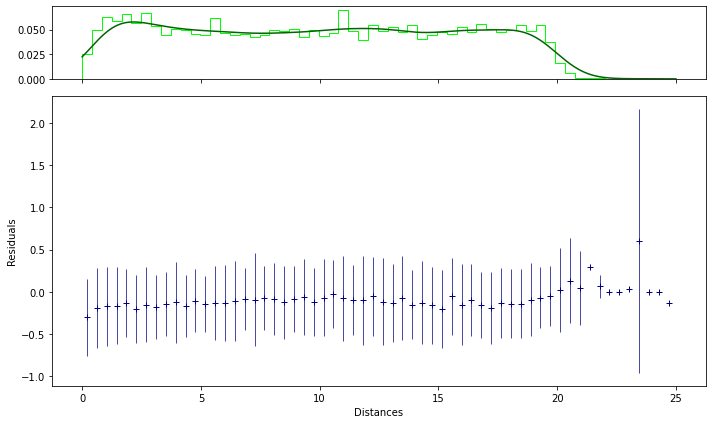

In [20]:
fig, (profile,ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10, 6),gridspec_kw = {'height_ratios':[1,4]})
ax1.errorbar(x, y, yerr=err_y, c="navy",fmt="+",elinewidth=0.7)
ax1.set_ylabel("Residuals")
ax1.set_xlabel("Distances")
profile.hist(df['distances'], bins=60, density=True, color="lime", histtype="step")
profile.plot(x_grid,kde.pdf(x_grid), c='darkgreen')
fig.tight_layout()


3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


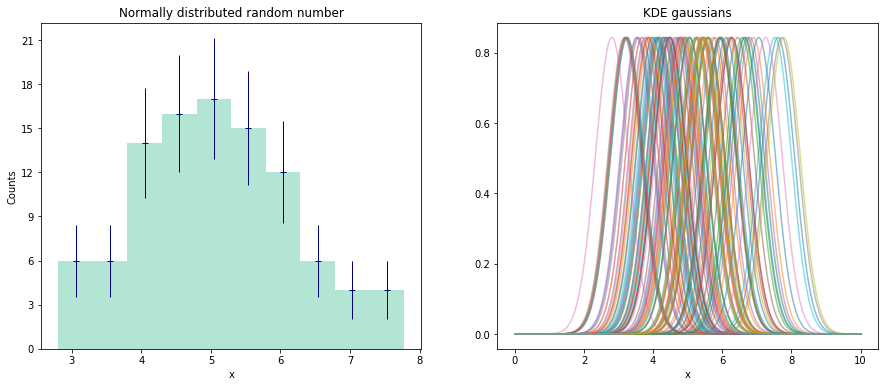

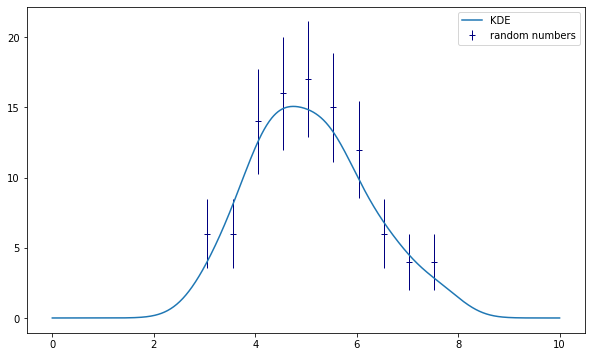

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import stats, integrate

N=100
x = np.random.normal(loc=5, scale=1, size=N)

#Plot histogram with errorbars
fig, ax = plt.subplots(ncols=2,figsize=(15, 6))
h, bins, _ = ax[0].hist(x, bins=10, color='mediumaquamarine', alpha=0.5)
ax[0].set_title('Normally distributed random number')
ax[0].set_xlabel("x")
ax[0].set_ylabel("Counts")
ax[0].yaxis.set_major_locator(MaxNLocator(integer=True)) #Restrict ticks to integer
x_bins = bins[:-1]+ 0.5*(bins[1:] - bins[:-1])
ax[0].errorbar(x_bins, h, yerr=np.sqrt(h), c="navy",fmt="+",elinewidth=1)


#KDE's gaussians
kde_x = np.linspace(0, 10, 1000)
kde_sigma = 1.06*np.std(x)*x.size**(-1/5)
kde = np.zeros((1000,))

for m in x:
    kde_y = stats.norm.pdf(kde_x, m, kde_sigma)
    kde += kde_y
    ax[1].plot(kde_x,kde_y, alpha=0.5)
ax[1].set_title("KDE gaussians")
ax[1].set_xlabel("x")


#Overlay KDE to the histogram 
N_kde = integrate.trapz(kde, x=kde_x)  
N_hist = integrate.trapz(h, x=x_bins)  

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(kde_x,kde/N_kde*N_hist, label="KDE")
ax.errorbar(x_bins, h, yerr=np.sqrt(h), c="navy",fmt="+",elinewidth=1)
ax.legend()
